In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt

# 设置随机种子以便复现
np.random.seed(42)

# 生成时间序列数据
date_rng = pd.date_range(start='2023-06-01', end='2023-06-30 23:50:00', freq='10min')
data = pd.DataFrame(date_rng, columns=['time'])

# 生成具有日周期性的温度数据（白天高，晚上低）
data['temperature'] = 20 + 10 * np.sin(2 * np.pi * data['time'].dt.hour / 24) + np.random.normal(0, 2, len(data))

# 生成具有日周期性的负载数据（白天高，晚上低）
data['load'] = 150 + 50 * np.cos(2 * np.pi * data['time'].dt.hour / 24) + np.random.normal(0, 10, len(data))

data['hour'] = data['time'].dt.hour
data['day'] = data['time'].dt.dayofweek

# 创建第一组标签（根据负载）
data['label_load'] = pd.qcut(data['load'], q=6, labels=['low1', 'low2', 'medium1', 'medium2', 'high1', 'high2'])

# 创建第二组标签（根据温度）
data['label_temp'] = pd.qcut(data['temperature'], q=3, labels=['low', 'medium', 'high'])

# 为负载数据加上噪声
data['load'] += np.random.normal(0, 5, len(data))

# 特征和目标
features = ['temperature', 'load', 'hour', 'day']
target_load = 'label_load'
target_temp = 'label_temp'

# 数据归一化
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

# 将标签转换为整数编码
label_mapping_load = {'low1': 0, 'low2': 1, 'medium1': 2, 'medium2': 3, 'high1': 4, 'high2': 5}
label_mapping_temp = {'low': 0, 'medium': 1, 'high': 2}

data['label_load'] = data['label_load'].map(label_mapping_load)
data['label_temp'] = data['label_temp'].map(label_mapping_temp)

# 创建滑动窗口数据集
def create_windowed_dataset(data, features, target_load, target_temp, look_back=24):
    X, y_load, y_temp = [], [], []
    for i in range(len(data) - look_back):
        X.append(data[features].values[i:i+look_back])
        y_load.append(data[target_load].values[i+look_back])
        y_temp.append(data[target_temp].values[i+look_back])
    return np.array(X), np.array(y_load), np.array(y_temp)

look_back = 24
X, y_load, y_temp = create_windowed_dataset(data, features, target_load, target_temp, look_back)

# 按时间顺序划分数据集
X_train, X_temp, y_load_train, y_load_temp, y_temp_train, y_temp_temp = train_test_split(
    X, y_load, y_temp, test_size=0.3, shuffle=False)
X_val, X_test, y_load_val, y_load_test, y_temp_val, y_temp_test = train_test_split(
    X_temp, y_load_temp, y_temp_temp, test_size=0.5, shuffle=False)

# 定义多头注意力机制
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0

        self.depth = d_model // num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, x, p=0.8):
        batch_size = tf.shape(x)[0]
        seq_len = tf.shape(x)[1]

        q = self.split_heads(self.wq(x), batch_size)
        k = self.split_heads(self.wk(x), batch_size)
        v = self.split_heads(self.wv(x), batch_size)

        attention_scores = tf.matmul(q, k, transpose_b=True)
        attention_scores = attention_scores / tf.math.sqrt(tf.cast(self.depth, tf.float32))

        mask = tf.cast(tf.random.uniform((batch_size, self.num_heads, 1, 1)) < p, tf.float32)
        mask = tf.tile(mask, [1, 1, seq_len, seq_len])

        attention_weights = tf.nn.softmax(attention_scores, axis=-1)

        masked_attention_weights = attention_weights * mask + (1 - mask) * tf.zeros_like(attention_weights)

        attention_output = tf.matmul(masked_attention_weights, v)
        attention_output = tf.transpose(attention_output, perm=[0, 2, 1, 3])
        attention_output = tf.reshape(attention_output, (batch_size, seq_len, self.d_model))

        output = self.dense(attention_output)
        return output

# 定义一个包含注意力机制、乘法层和归一化层的box
class AttentionBox(tf.keras.layers.Layer):
    def __init__(self, num_heads, d_model):
        super(AttentionBox, self).__init__()
        self.mha = MultiHeadAttention(num_heads, d_model)
        self.relu = tf.keras.layers.ReLU()
        self.dense_proj = tf.keras.layers.Dense(d_model)
        self.multiply = tf.keras.layers.Multiply()
        self.norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs, p=0.8):
        x = self.mha(inputs, p=p)
        x = self.relu(x)
        inputs_proj = self.dense_proj(inputs)
        x = self.multiply([x, inputs_proj])
        x = self.norm(x)
        return x

# 使用Functional API构建模型
input_layer = tf.keras.layers.Input(shape=(look_back, len(features)))
x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu')(input_layer)
x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, activation='relu')(x)
x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
x = AttentionBox(num_heads=8, d_model=256)(x)
x = AttentionBox(num_heads=8, d_model=256)(x)
x = AttentionBox(num_heads=8, d_model=256)(x)
x = tf.keras.layers.Dense(256, activation='relu')(x)

output1 = tf.keras.layers.Dense(6, activation='softmax', name='output1')(x[:, -1, :])
output2 = tf.keras.layers.Dense(3, activation='softmax', name='output2')(x[:, -1, :])

model = tf.keras.Model(inputs=input_layer, outputs=[output1, output2])

model.compile(
    optimizer='adam',
    loss={'output1': 'sparse_categorical_crossentropy', 'output2': 'sparse_categorical_crossentropy'},
    metrics={'output1': 'accuracy', 'output2': 'accuracy'}
)

# 定义回调函数
early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# 训练模型
history = model.fit(
    X_train, {'output1': y_load_train, 'output2': y_temp_train},
    epochs=100,
    batch_size=32,
    validation_data=(X_val, {'output1': y_load_val, 'output2': y_temp_val}),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
 1/94 ━━━━━━━━━━━━━━━━━━━━ 8:30 5s/step - loss: 2.8853 - output1_accuracy: 0.1562 - output2_accuracy: 0.4062

2024-07-10 11:42:24.869519: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.
2024-07-10 11:42:24.883112: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.
2024-07-10 11:42:24.891363: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.
2024-07-10 11:42:24.891622: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.
2024-07-10 11:42:24.902589: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 8388608 exceeds 10% of free system memory.


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 159ms/step - loss: 2.3680 - output1_accuracy: 0.3425 - output2_accuracy: 0.6128 - val_loss: 1.4372 - val_output1_accuracy: 0.5978 - val_output2_accuracy: 0.8106 - learning_rate: 0.0010
Epoch 2/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 156ms/step - loss: 1.4211 - output1_accuracy: 0.5235 - output2_accuracy: 0.8224 - val_loss: 1.3598 - val_output1_accuracy: 0.5885 - val_output2_accuracy: 0.8323 - learning_rate: 0.0010
Epoch 3/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 155ms/step - loss: 1.2365 - output1_accuracy: 0.5855 - output2_accuracy: 0.8419 - val_loss: 1.2720 - val_output1_accuracy: 0.6102 - val_output2_accuracy: 0.8370 - learning_rate: 0.0010
Epoch 4/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 155ms/step - loss: 1.2251 - output1_accuracy: 0.5815 - output2_accuracy: 0.8483 - val_loss: 1.2334 - val_output1_accuracy: 0.6087 - val_output2_accuracy: 0.8385 - learning_rate: 0.0010
Epoch 5/100
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 164ms/step - loss: 1.2048 - output1_accuracy: 0.5819 - ou

IndexError: list index out of range

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 1.2263 - output1_accuracy: 0.5693 - output2_accuracy: 0.8658
Test results: [1.208740472793579, 0.5844961404800415, 0.8589147329330444]
Test Loss (load): 1.2087
Test Accuracy (load): 0.5845
Test Loss (temp): 0.8589
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


Load Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.72      0.68       105
           1       0.50      0.46      0.48       108
           2       0.59      0.58      0.58       111
           3       0.51      0.56      0.54       102
           4       0.55      0.34      0.42       117
           5       0.65      0.85      0.74       102

    accuracy                           0.58       645
   macro avg       0.57      0.59      0.57       645
weighted avg       0.57      0.58      0.57       645

Load Confusion Matrix:
[[76 26  3  0  0  0]
 [40 50 17  1  0  0]
 [ 2 25 64 20  0  0]
 [ 0  0 23 57 18  4]
 [ 0  0  1 33 40 43]
 [ 0  0  0  0 15 87]]
Temperature Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.86      0.89       246
           1       0.77      0.78      0.77       213
           2       0.85      0.91      0.88       186

    accuracy              

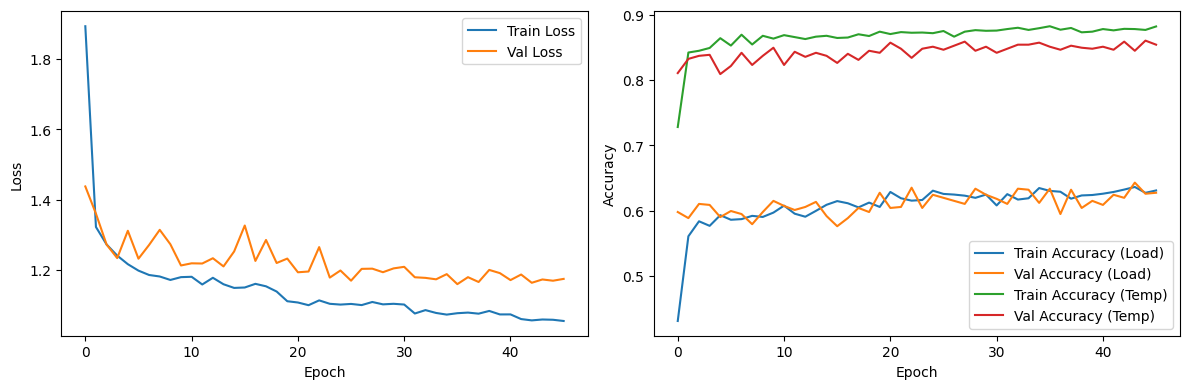

In [12]:
# 评估模型
test_results = model.evaluate(X_test, {'output1': y_load_test, 'output2': y_temp_test})
print(f"Test results: {test_results}")
print(f"Test Loss (load): {test_results[0]:.4f}")
print(f"Test Accuracy (load): {test_results[1]:.4f}")
print(f"Test Loss (temp): {test_results[2]:.4f}")
if len(test_results) > 3:
    print(f"Test Accuracy (temp): {test_results[3]:.4f}")

# 预测
y_pred_load, y_pred_temp = model.predict(X_test)
y_pred_load_classes = np.argmax(y_pred_load, axis=1)
y_pred_temp_classes = np.argmax(y_pred_temp, axis=1)

# 计算额外的指标
from sklearn.metrics import classification_report, confusion_matrix

print("Load Classification Report:")
print(classification_report(y_load_test, y_pred_load_classes))
print("Load Confusion Matrix:")
print(confusion_matrix(y_load_test, y_pred_load_classes))

print("Temperature Classification Report:")
print(classification_report(y_temp_test, y_pred_temp_classes))
print("Temperature Confusion Matrix:")
print(confusion_matrix(y_temp_test, y_pred_temp_classes))

# 保存模型
model.save('dual_output_model.h5')

# 可视化训练过程
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['output1_accuracy'], label='Train Accuracy (Load)')
plt.plot(history.history['val_output1_accuracy'], label='Val Accuracy (Load)')
plt.plot(history.history['output2_accuracy'], label='Train Accuracy (Temp)')
plt.plot(history.history['val_output2_accuracy'], label='Val Accuracy (Temp)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()